# This notebook is for developing plotting functions

In [4]:
import pandas as pd
import pandas as pd
import numpy as np
import obspy

from obspy.clients.fdsn import Client
from obspy import Stream,UTCDateTime
from pnwstore.mseed import WaveformClient
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from obspy.geodetics import locations2degrees, degrees2kilometers
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

from obspy.clients.fdsn import Client as FDSNClient




In [ ]:
def subplots_cluster_scale_rand(mycatalog, mycatalog_picks, all_picks, channel, fig_title, file_title):
    """
    mycatalog: dataframe that contains only the unique events (e.g., mycatalog_picks.drop_duplicates(subset=['idx']).copy())
    mycatalog_picks: all pick assignments csv file (e.g., pd.read_csv('../data/datasets_OR/all_pick_assignments_OR.csv'))
    all_picks: all_picks csv file (e.g., pd.read_csv('../data/datasets_OR_010/all_picks_OR'))
    channel: specify the direction of the channel (i.e., "?HZ", "?HE" or "?HN")
    fig_title: title in a string
    file_title: file title in a string
    """
        
    # Define the clients 
    client_waveform = WaveformClient()
    client2 = Client("IRIS")
    client_ncedc = Client('NCEDC')

    # Plot the earthquake moveout for one of the unmatched events for all stations 
    events = mycatalog
    picks = mycatalog_picks
    events['datetime'] = pd.to_datetime(events['time'], utc=True)

    networks = all_picks['station_network_code'].drop_duplicates()
    networks = ','.join(networks)
    # print(networks)
    p = PdfPages(file_title) 
    
    # Randomly select 5 events
    # random_events = events.sample(n=5, random_state=42)
    random_events = events.sample(n=5)

    for idx in tqdm(random_events['idx'], total=len(random_events['idx'])):
        
        picks_idx = picks.loc[picks['idx'] == idx]
        pick_sta = np.unique(picks_idx['station'])

        otime = UTCDateTime(str(events[events['idx'] == idx]["datetime"].values[0]))
        distances = []
        max_dist = 10
        min_dist = 0

        for station in pick_sta:
            sta_inv = client2.get_stations(network=networks,
                                           station=station, channel="?H?", 
                                           starttime=otime - 1e8, endtime=otime + 1e8, level="response")
            if len(sta_inv) == 0:
                continue
            
            _network = sta_inv[0].code
            slat = sta_inv[0][0].latitude
            slon = sta_inv[0][0].longitude
            olat = events.loc[events['idx']==idx, 'latitude'].values[0]
            olon = events.loc[events['idx']==idx, 'longitude'].values[0]

            dis1 = locations2degrees(olat, olon, slat, slon)
            dist = degrees2kilometers(dis1)

            distances.append([None, _network, station, dist])

        # Sort distances
        distances = sorted(distances, key=lambda item: item[-1])

        # Set up to define the xlim and ylim
        max_y = 0
        min_y = 0
        min_y_count = 0 

        max_x = 0
        min_x = 0
        min_x_count= 0

        # Create a figure
        fig, axs = plt.subplots(1, 4, figsize=(18, 6))
        gs = fig.add_gridspec(3, hspace=0, figure=fig)
        starttime = otime - 30
        endtime = otime + 120
        # Define texts
        texts = []

        for i, ii in enumerate(distances):
            if ii[1] in ['NC', 'BK']:
                st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel, starttime=starttime, endtime=endtime)
            elif ii[1] in networks: 
                st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel, starttime=starttime, endtime=endtime)
            else: 
                st = Stream()
                print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                continue

            if len(st) == 0:
                continue
            sta_picks = picks_idx[picks_idx['station'] == ii[2]]
            p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
            s_picks = sta_picks.loc[sta_picks['phase'] == 'S']

            if len(s_picks) > 0:
                if max_x < UTCDateTime(s_picks.iloc[0]['time_pick']) - starttime:
                    max_x = UTCDateTime(s_picks.iloc[0]['time_pick']+5) - starttime
            elif len(p_picks) > 0:
                if max_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime: 
                    max_x = UTCDateTime(p_picks.iloc[0]['time_pick']+5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue 

            if len(p_picks) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime
                        min_x_count += 1           
                else:
                    if min_x >= UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime            
            elif len(s_picks) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5)- starttime
                        min_x_count += 1                
                else:
                    if min_x >= UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue    

            if min_y_count == 0:
                if min_y < ii[3]:
                    min_y = ii[3] - 5
                    min_y_count += 1           
            else:
                if min_y >= ii[3]:
                    min_y = ii[3] - 5 

            max_y = ii[3] + 5

        scaling_factor = (1/2) * (max_y - min_y)

        chs = []  # Initialize chs here
        for i, ii in enumerate(distances):

            if ii[1] in ['NC', 'BK']:
                st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel, starttime=starttime, endtime=endtime)
            elif ii[1] in networks: 
                st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel, starttime=starttime, endtime=endtime)
            else: 
                st = Stream()
                print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                continue

            if len(st) == 0:
                continue

            _st = Stream()
            has_HH = bool(st.select(channel="HH?"))
            has_BH = bool(st.select(channel="BH?"))

            if has_HH and has_BH:
                _st += st.select(channel="HH?")
            elif has_HH:
                _st += st.select(channel="HH?")
            elif has_BH:
                _st += st.select(channel="BH?")

            st = _st

            st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
            st.taper(max_percentage=0.05)
            st.filter(type='bandpass', freqmin=2, freqmax=25)
            st.merge(fill_value='interpolate')

            unique_channels = set(tr.stats.channel for tr in st)
            selected_traces = []

            for ch in unique_channels:
                selected_traces.append(next(tr for tr in st if tr.stats.channel == ch))
            st = Stream(selected_traces)

            trim_st = st.copy()
            sta_picks = picks_idx[picks_idx['station'] == ii[2]]
            p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
            s_picks = sta_picks.loc[sta_picks['phase'] == 'S']

            print(trim_st)
            for iax in range(len(trim_st)):
                sampling_rate = trim_st[iax].stats.sampling_rate
                trim_st = trim_st.normalize()
                if i == 0:
                    chs.append(str(trim_st[iax].stats.channel))

                if len(p_picks) > 0:
                    tp = UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30
                    i1 = int((tp-5) * sampling_rate)
                    i2 = int((tp+15) * sampling_rate)
                elif len(s_picks) > 0:
                    ts = UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30
                    i1 = int((ts-10) * sampling_rate)
                    i2 = int((ts+10) * sampling_rate)
                else:
                    print(f"WARNING: No pick time for {ii[1]}.{ii[2]}.{channel} on {otime}.")

                offsets1 = ii[3]
                try: 
                    wave = trim_st[iax].data
                    wave = wave / (np.nanmax(wave[i1:i2], axis=-1) * 10)
                except:
                    continue 

                # Plot the waveform
                axs[iax].plot(trim_st[iax].times(), wave * scaling_factor + offsets1, 
                              color='black', alpha=0.7, lw=0.5)

                # Add the label only once per channel
                if i == 0:
                    axs[iax].plot([], [], color='black', label=f"{trim_st[iax].stats.channel}")

                if len(p_picks) > 0:
                    axs[iax].vlines(UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='r')
                if len(s_picks) > 0:
                    axs[iax].vlines(UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='b')

            texts.append([ii[2], ii[3]])

        for iax in range(3):
            for i, ii in enumerate(texts):
                offsets1 = ii[1]
                axs[iax].text(max_x + 0.5, offsets1, 
                              [ii[0]], fontsize=8, verticalalignment='bottom')
            if chs:  # Only set ncol if chs is not empty
                axs[iax].legend(loc='upper right', ncol=len(chs), handlelength=0,handletextpad=0, columnspacing=0.5)  # Adjust handletextpad and columnspacing
            axs[iax].set_ylim([min_y, max_y])
            axs[iax].set_xlim([min_x, max_x])
            axs[iax].grid(alpha=0.5)

        fig.supxlabel('Time [sec]', y=0.07)
        fig.supylabel('Distance [km]')
        fig.suptitle(f"{fig_title}: Origin Time={otime}, \n Latitude={round(events[events['idx']==idx]['latitude'].values[0], 2)}, Longtitude={round(events[events['idx']==idx]['longitude'].values[0], 2)}, Depth={round(events[events['idx']==idx]['depth'].values[0], 2)}", y=1)

        m = Basemap(projection='merc', llcrnrlat=40, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-120, resolution='i', ax=axs[3])
        m.drawcoastlines()
        m.drawcountries()
        m.drawstates()
        m.drawmapboundary()
        m.drawparallels(np.arange(40, 51, 1), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-130, -119, 1), labels=[0, 0, 0, 1])
        x, y = m(events[events['idx']==idx]['longitude'].values[0], events[events['idx']==idx]['latitude'].values[0])
        m.plot(x, y, 'ro', markersize=9)
        axs[3].set_title('Event Location')
        
        fig.savefig(p, format='pdf')  

    p.close()

In [ ]:
# def subplots_cluster_scale_rand(mycatalog, mycatalog_picks, all_picks, channel, fig_title, file_title):
#     """
#     mycatalog: dataframe that contains only the unique events (e.g., mycatalog_picks.drop_duplicates(subset=['idx']).copy())
#     mycatalog_picks: all pick assignments csv file (e.g., pd.read_csv('../data/datasets_OR/all_pick_assignments_OR.csv'))
#     all_picks: all_picks csv file (e.g., pd.read_csv('../data/datasets_OR_010/all_picks_OR'))
#     channel: specify the direction of the channel (i.e., "?HZ", "?HE" or "?HN")
#     fig_title: title in a string
#     file_title: file title in a string
#     """
        
#     # Define the clients 
#     client_waveform = WaveformClient()
#     client2 = Client("IRIS")
#     client_ncedc = Client('NCEDC')

#     # Plot the earthquake moveout for one of the unmatched events for all stations 
#     events = mycatalog
#     picks = mycatalog_picks
#     events['datetime'] = pd.to_datetime(events['time'], utc=True)

#     networks = all_picks['station_network_code'].drop_duplicates()
#     networks = ','.join(networks)

#     p = PdfPages(file_title) 
    
#     # Randomly select 5 events
#     random_events = events.sample(n=5, random_state=42)
    
#     for idx in tqdm(random_events['idx'], total=len(random_events['idx'])):
#         print(idx)
#         picks_idx = picks.loc[picks['idx'] == idx]
#         pick_sta = np.unique(picks_idx['station'])

#         otime = UTCDateTime(str(events[events['idx'] == idx]["datetime"].values[0]))
#         distances = []
#         max_dist = 10
#         min_dist = 0

#         for station in pick_sta:
#             sta_inv = client2.get_stations(network=networks,
#                                            station=station, channel="?H?", 
#                                            starttime=otime - 1e8, endtime=otime + 1e8, level="response")
#             if len(sta_inv) == 0:
#                 continue
            
#             _network = sta_inv[0].code
#             slat = sta_inv[0][0].latitude
#             slon = sta_inv[0][0].longitude
#             olat = events.loc[events['idx']==idx, 'latitude'].values[0]
#             olon = events.loc[events['idx']==idx, 'longitude'].values[0]

#             dis1 = locations2degrees(olat, olon, slat, slon)
#             dist = degrees2kilometers(dis1)

#             distances.append([None, _network, station, dist])

#         # Sort distances
#         distances = sorted(distances, key=lambda item: item[-1])

#         # Set up to define the xlim and ylim
#         max_y = 0
#         min_y = 0
#         min_y_count = 0 

#         max_x = 0
#         min_x = 0
#         min_x_count= 0

#         # Create a figure
#         fig, axs = plt.subplots(1, 4, figsize=(18, 6))
#         gs = fig.add_gridspec(3, hspace=0, figure=fig)
#         starttime = otime - 30
#         endtime = otime + 120

#         # Define texts
#         texts = []

#         for i, ii in enumerate(distances):

#             if ii[1] in ['NC', 'BK']:
#                 st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel, starttime=starttime, endtime=endtime)
#             elif ii[1] in networks: 
#                 st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel, starttime=starttime, endtime=endtime)
#             else: 
#                 st = Stream()
#                 print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
#                 continue

#             if len(st) == 0:
#                 continue

#             sta_picks = picks_idx[picks_idx['station'] == ii[2]]
#             p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
#             s_picks = sta_picks.loc[sta_picks['phase'] == 'S']

#             if len(s_picks) > 0:
#                 if max_x < UTCDateTime(s_picks.iloc[0]['time_pick']) - starttime:
#                     max_x = UTCDateTime(s_picks.iloc[0]['time_pick']+5) - starttime
#             elif len(p_picks) > 0:
#                 if max_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime: 
#                     max_x = UTCDateTime(p_picks.iloc[0]['time_pick']+5) - starttime
#             else:
#                 print('No picks for this station. Skipping.')
#                 continue 

#             if len(p_picks) > 0:
#                 if min_x_count == 0:
#                     if min_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
#                         min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime
#                         min_x_count += 1           
#                 else:
#                     if min_x >= UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
#                         min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime            
#             elif len(s_picks) > 0:
#                 if min_x_count == 0:
#                     if min_x < UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
#                         min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5)- starttime
#                         min_x_count += 1                
#                 else:
#                     if min_x >= UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
#                         min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5) - starttime
#             else:
#                 print('No picks for this station. Skipping.')
#                 continue    

#             if min_y_count == 0:
#                 if min_y < ii[3]:
#                     min_y = ii[3] - 5
#                     min_y_count += 1           
#             else:
#                 if min_y >= ii[3]:
#                     min_y = ii[3] - 5 

#             max_y = ii[3] + 5

#         scaling_factor = (1/2) * (max_y - min_y)

#         chs = []  # Initialize chs here
#         for i, ii in enumerate(distances):

#             if ii[1] in ['NC', 'BK']:
#                 st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel, starttime=starttime, endtime=endtime)
#             elif ii[1] in networks: 
#                 st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel, starttime=starttime, endtime=endtime)
#             else: 
#                 st = Stream()
#                 print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
#                 continue

#             if len(st) == 0:
#                 continue

#             _st = Stream()
#             has_HH = bool(st.select(channel="HH?"))
#             has_BH = bool(st.select(channel="BH?"))

#             if has_HH and has_BH:
#                 _st += st.select(channel="HH?")
#             elif has_HH:
#                 _st += st.select(channel="HH?")
#             elif has_BH:
#                 _st += st.select(channel="BH?")

#             st = _st

#             st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
#             st.taper(max_percentage=0.05)
#             st.filter(type='bandpass', freqmin=2, freqmax=25)
#             st.merge(fill_value='interpolate')

#             unique_channels = set(tr.stats.channel for tr in st)
#             selected_traces = []

#             for ch in unique_channels:
#                 selected_traces.append(next(tr for tr in st if tr.stats.channel == ch))
#             st = Stream(selected_traces)

#             trim_st = st.copy()
#             sta_picks = picks_idx[picks_idx['station'] == ii[2]]
#             p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
#             s_picks = sta_picks.loc[sta_picks['phase'] == 'S']

#             print(trim_st)
#             print('test')
             
#             for iax in range(len(trim_st)):
#                 sampling_rate = trim_st[iax].stats.sampling_rate
#                 trim_st = trim_st.normalize()
#                 if i == 0:
#                     chs.append(str(trim_st[iax].stats.channel))

#                 if len(p_picks) > 0:
#                     tp = UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30
#                     i1 = int((tp-5) * sampling_rate)
#                     i2 = int((tp+15) * sampling_rate)
#                 elif len(s_picks) > 0:
#                     ts = UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30
#                     i1 = int((ts-10) * sampling_rate)
#                     i2 = int((ts+10) * sampling_rate)
#                 else:
#                     print(f"WARNING: No pick time for {ii[1]}.{ii[2]}.{channel} on {otime}.")

#                 offsets1 = ii[3]
#                 try: 
#                     wave = trim_st[iax].data
#                     wave = wave / (np.nanmax(wave[i1:i2], axis=-1) * 10)
#                 except:
#                     continue 

#                 # Plot the waveform
#                 axs[iax].plot(trim_st[iax].times(), wave * scaling_factor + offsets1, 
#                               color='black', alpha=0.7, lw=0.5)

#                 # Add the label only once per channel
#                 if i == 0:
#                     axs[iax].plot([], [], color='black', label=f"{trim_st[iax].stats.channel}")

#                 if len(p_picks) > 0:
#                     axs[iax].vlines(UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
#                                     offsets1 + (1/35) * scaling_factor, color='r')
#                 if len(s_picks) > 0:
#                     axs[iax].vlines(UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
#                                     offsets1 + (1/35) * scaling_factor, color='b')

#             texts.append([ii[2], ii[3]])

#         epsilon = 1e-5
#         for iax in range(3):
#             for i, ii in enumerate(texts):
#                 offsets1 = ii[1]
#                 axs[iax].text(max_x + 0.5, offsets1, 
#                               [ii[0]], fontsize=8, verticalalignment='bottom')
#             if chs:  # Only set ncol if chs is not empty
#                 axs[iax].legend(loc='upper right', ncol=len(chs), handletextpad=0.5, columnspacing=0.5)  # Adjust handletextpad and columnspacing
#             if min_y == max_y:
#                 min_y -= epsilon
#                 max_y += epsilon
#             if min_x == max_x:
#                 min_x -= epsilon
#                 max_x += epsilon
#             axs[iax].set_ylim([min_y, max_y])
#             axs[iax].set_xlim([min_x, max_x])
#             axs[iax].grid(alpha=0.5)

#         fig.supxlabel('Time [sec]', y=0.07)
#         fig.supylabel('Distance [km]')
#         fig.suptitle(f"{fig_title}: Origin Time={otime}, \n Latitude={round(events[events['idx']==idx]['latitude'].values[0], 2)}, Longtitude={round(events[events['idx']==idx]['longitude'].values[0], 2)}, Depth={round(events[events['idx']==idx]['depth'].values[0], 2)}", y=1)

#         m = Basemap(projection='merc', llcrnrlat=40, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-120, resolution='i', ax=axs[3])
#         m.drawcoastlines()
#         m.drawcountries()
#         m.drawstates()
#         m.drawmapboundary()
#         m.drawparallels(np.arange(40, 51, 1), labels=[1, 0, 0, 0])
#         m.drawmeridians(np.arange(-130, -119, 1), labels=[0, 0, 0, 1])
#         x, y = m(events[events['idx']==idx]['longitude'].values[0], events[events['idx']==idx]['latitude'].values[0])
#         m.plot(x, y, 'ro', markersize=9)
#         axs[3].set_title('Event Location')
        
#         fig.savefig(p, format='pdf')  

#     p.close()

In [116]:
year = 'swa_shelf_trench'
mycatalog = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/new_events_filtered_{year}.csv',index_col=0)
mycatalog_picks = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/all_pick_assignments_{year}.csv',index_col=0)
all_picks = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/all_picks_all_years_for_assoc_{year}.csv',index_col=0)

  0%|          | 0/5 [00:00<?, ?it/s]

[[None, '7D', 'FN02C', 2.1661236309821494], [None, '7D', 'FN04C', 15.548469529813046], [None, '7D', 'FN12C', 54.6366072028644], [None, '7D', 'J49C', 58.45729864425352]]
48207
48207
48207
48207
3 Trace(s) in Stream:
7D.FN02C..HHZ | 2014-05-15T08:55:35.917300Z - 2014-05-15T08:58:05.917300Z | 125.0 Hz, 18751 samples
7D.FN02C..HH2 | 2014-05-15T08:55:35.917300Z - 2014-05-15T08:58:05.917300Z | 125.0 Hz, 18751 samples
7D.FN02C..HH1 | 2014-05-15T08:55:35.917300Z - 2014-05-15T08:58:05.917300Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN04C..HHZ | 2014-05-15T08:55:35.919300Z - 2014-05-15T08:58:05.919300Z | 125.0 Hz, 18751 samples
7D.FN04C..HH2 | 2014-05-15T08:55:35.919300Z - 2014-05-15T08:58:05.919300Z | 125.0 Hz, 18751 samples
7D.FN04C..HH1 | 2014-05-15T08:55:35.919300Z - 2014-05-15T08:58:05.919300Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN12C..HHZ | 2014-05-15T08:55:35.919600Z - 2014-05-15T08:58:05.919600Z | 125.0 Hz, 18751 samples
7D.FN12C..HH2 | 2014-05-15T08:55:35.91960

 20%|██        | 1/5 [00:04<00:17,  4.39s/it]

[[None, '7D', 'FN02C', 22.336726574226034], [None, '7D', 'FN04C', 24.157705809862563], [None, '7D', 'FN07C', 35.536273927769855], [None, '7D', 'FN09C', 41.252376153547765], [None, '7D', 'FN19C', 46.8484289584483]]
16366
16366
16366
16366
16366
3 Trace(s) in Stream:
7D.FN02C..HHZ | 2014-02-08T12:07:41.362600Z - 2014-02-08T12:10:11.362600Z | 125.0 Hz, 18751 samples
7D.FN02C..HH2 | 2014-02-08T12:07:41.362600Z - 2014-02-08T12:10:11.362600Z | 125.0 Hz, 18751 samples
7D.FN02C..HH1 | 2014-02-08T12:07:41.362600Z - 2014-02-08T12:10:11.362600Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN04C..HHZ | 2014-02-08T12:07:41.363000Z - 2014-02-08T12:10:11.363000Z | 125.0 Hz, 18751 samples
7D.FN04C..HH2 | 2014-02-08T12:07:41.363000Z - 2014-02-08T12:10:11.363000Z | 125.0 Hz, 18751 samples
7D.FN04C..HH1 | 2014-02-08T12:07:41.363000Z - 2014-02-08T12:10:11.363000Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN07C..HHZ | 2014-02-08T12:07:41.367900Z - 2014-02-08T12:10:11.367900Z | 125.0 Hz, 1875

 40%|████      | 2/5 [00:09<00:14,  4.77s/it]

[[None, '7D', 'FN07A', 6.260971724563665], [None, '7D', 'FN14A', 28.32758709688387], [None, '7D', 'J50A', 42.56645698279681], [None, '7D', 'J42A', 103.91679993099557]]
1956
1956
1956
1956
3 Trace(s) in Stream:
7D.FN07A..HHZ | 2012-07-16T14:45:04.349000Z - 2012-07-16T14:47:34.349000Z | 125.0 Hz, 18751 samples
7D.FN07A..HH2 | 2012-07-16T14:45:04.349000Z - 2012-07-16T14:47:34.349000Z | 125.0 Hz, 18751 samples
7D.FN07A..HH1 | 2012-07-16T14:45:04.349000Z - 2012-07-16T14:47:34.349000Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN14A..HHZ | 2012-07-16T14:45:04.345000Z - 2012-07-16T14:47:34.345000Z | 125.0 Hz, 18751 samples
7D.FN14A..HH2 | 2012-07-16T14:45:04.345000Z - 2012-07-16T14:47:34.345000Z | 125.0 Hz, 18751 samples
7D.FN14A..HH1 | 2012-07-16T14:45:04.345000Z - 2012-07-16T14:47:34.345000Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.J50A..HHZ | 2012-07-16T14:45:04.349000Z - 2012-07-16T14:47:34.349000Z | 125.0 Hz, 18751 samples
7D.J50A..HH2 | 2012-07-16T14:45:04.349000Z - 20

 60%|██████    | 3/5 [00:14<00:10,  5.02s/it]

[[None, '7D', 'FN07C', 11.906966754646403], [None, '7D', 'FN09C', 19.615929514474185], [None, '7D', 'FN01C', 22.82087834319764], [None, '7D', 'FN12C', 37.4534015157834]]
9282
9282
9282
9282
3 Trace(s) in Stream:
7D.FN07C..HHZ | 2014-01-23T08:23:44.650900Z - 2014-01-23T08:26:14.650900Z | 125.0 Hz, 18751 samples
7D.FN07C..HH2 | 2014-01-23T08:23:44.650900Z - 2014-01-23T08:26:14.650900Z | 125.0 Hz, 18751 samples
7D.FN07C..HH1 | 2014-01-23T08:23:44.650900Z - 2014-01-23T08:26:14.650900Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN09C..HHZ | 2014-01-23T08:23:44.648000Z - 2014-01-23T08:26:14.648000Z | 125.0 Hz, 18751 samples
7D.FN09C..HH2 | 2014-01-23T08:23:44.648000Z - 2014-01-23T08:26:14.648000Z | 125.0 Hz, 18751 samples
7D.FN09C..HH1 | 2014-01-23T08:23:44.648000Z - 2014-01-23T08:26:14.648000Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN01C..HHZ | 2014-01-23T08:23:44.645800Z - 2014-01-23T08:26:14.645800Z | 125.0 Hz, 18751 samples
7D.FN01C..HH2 | 2014-01-23T08:23:44.645800Z 

 80%|████████  | 4/5 [00:19<00:04,  4.78s/it]

[[None, '7D', 'FN07C', 9.7173021755374], [None, '7D', 'FN04C', 14.804397763620429], [None, '7D', 'FN01C', 28.605735855218036], [None, '7D', 'J49C', 44.783362784459364]]
53265
53265
53265
53265
3 Trace(s) in Stream:
7D.FN07C..HHZ | 2014-05-25T11:11:36.412600Z - 2014-05-25T11:14:06.412600Z | 125.0 Hz, 18751 samples
7D.FN07C..HH2 | 2014-05-25T11:11:36.412600Z - 2014-05-25T11:14:06.412600Z | 125.0 Hz, 18751 samples
7D.FN07C..HH1 | 2014-05-25T11:11:36.412600Z - 2014-05-25T11:14:06.412600Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN04C..HHZ | 2014-05-25T11:11:36.411600Z - 2014-05-25T11:14:06.411600Z | 125.0 Hz, 18751 samples
7D.FN04C..HH2 | 2014-05-25T11:11:36.411600Z - 2014-05-25T11:14:06.411600Z | 125.0 Hz, 18751 samples
7D.FN04C..HH1 | 2014-05-25T11:11:36.411600Z - 2014-05-25T11:14:06.411600Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN01C..HHZ | 2014-05-25T11:11:36.413000Z - 2014-05-25T11:14:06.413000Z | 125.0 Hz, 18751 samples
7D.FN01C..HH2 | 2014-05-25T11:11:36.41300

100%|██████████| 5/5 [00:23<00:00,  4.65s/it]


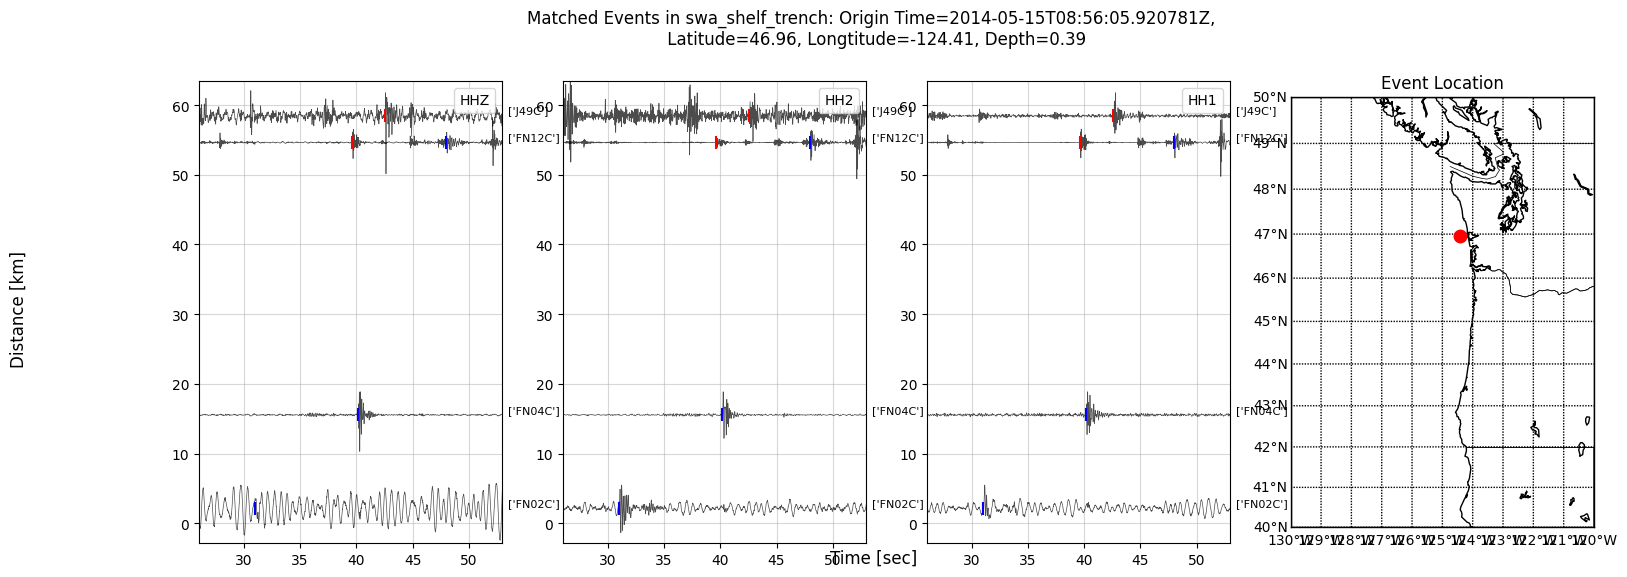

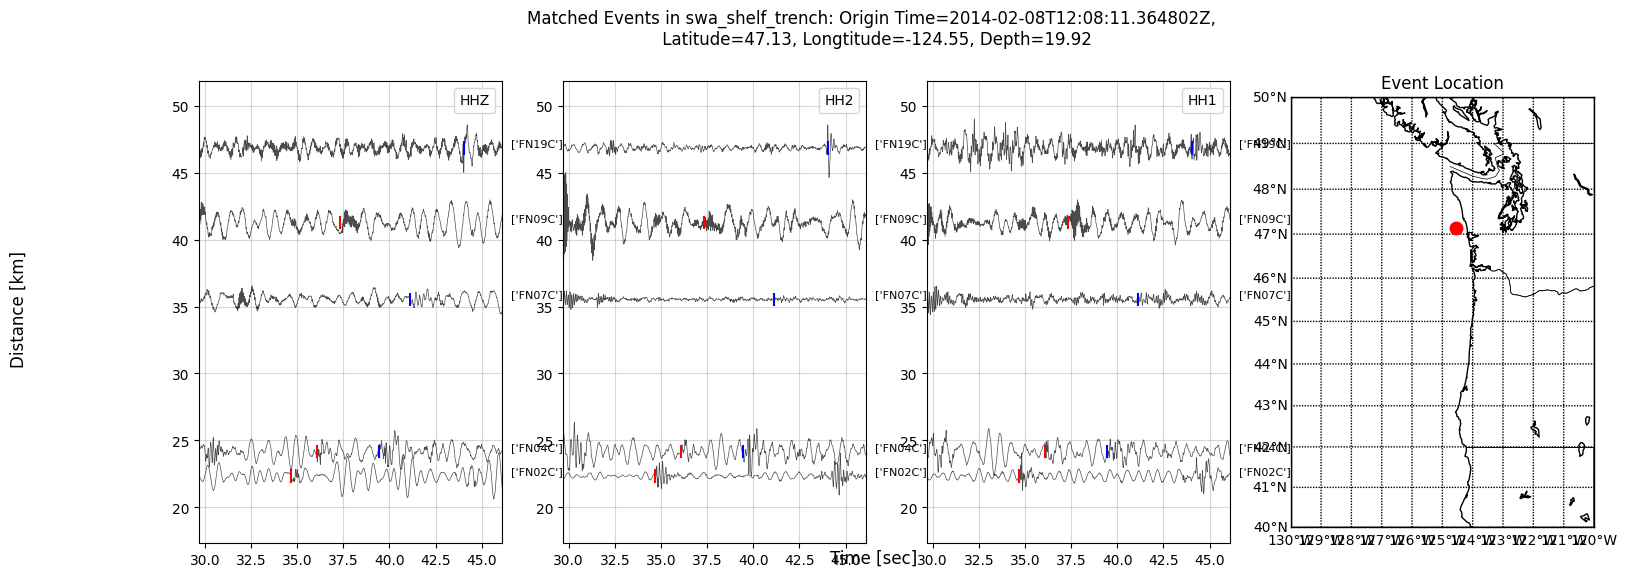

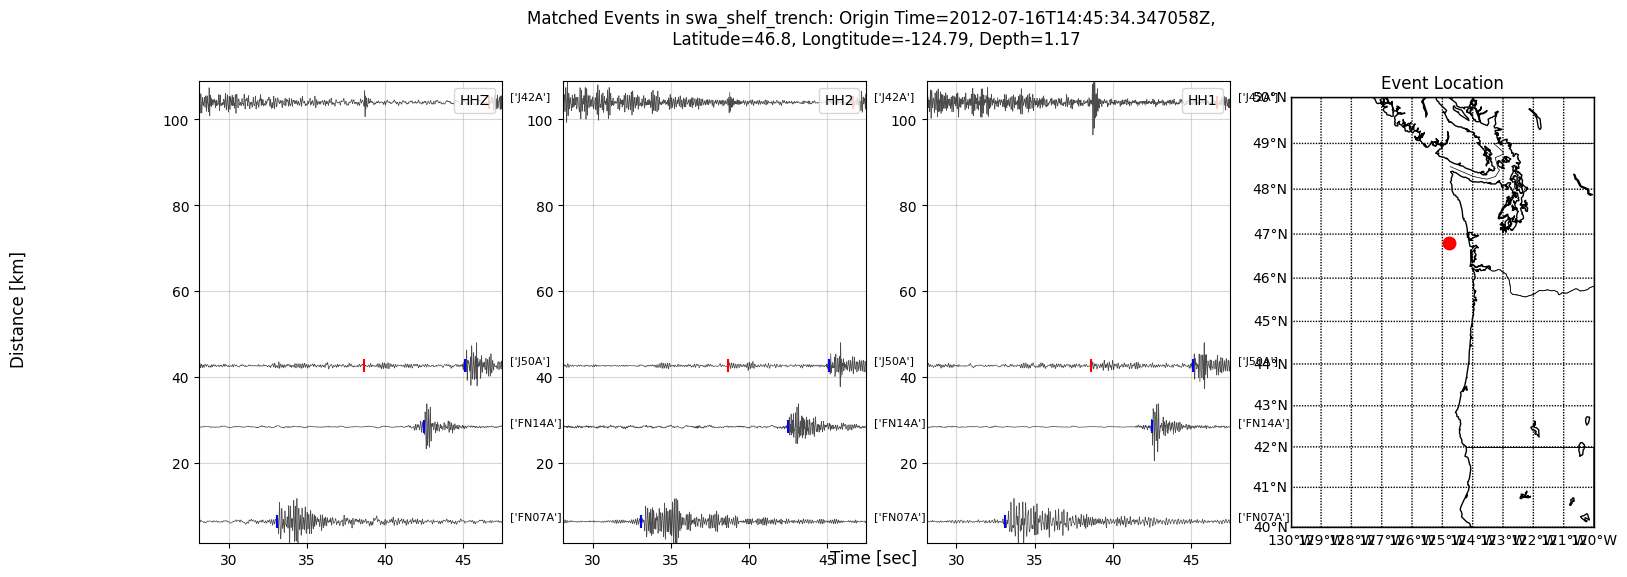

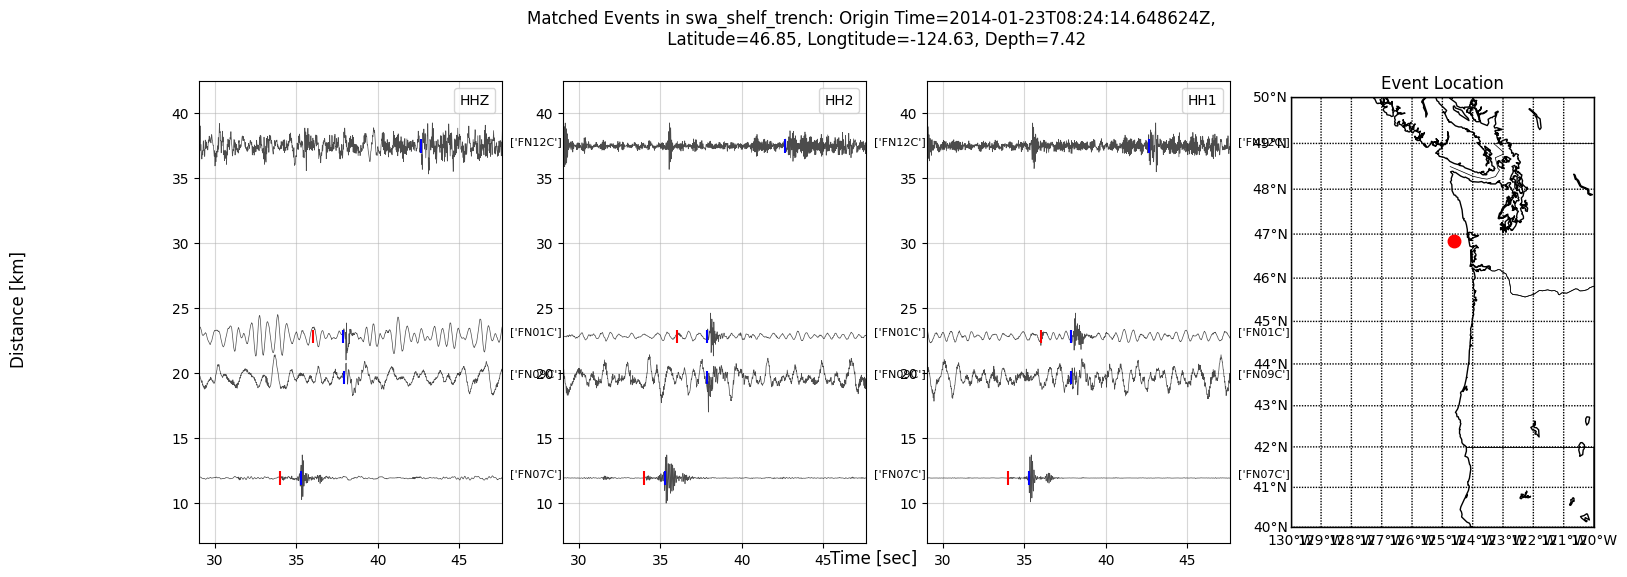

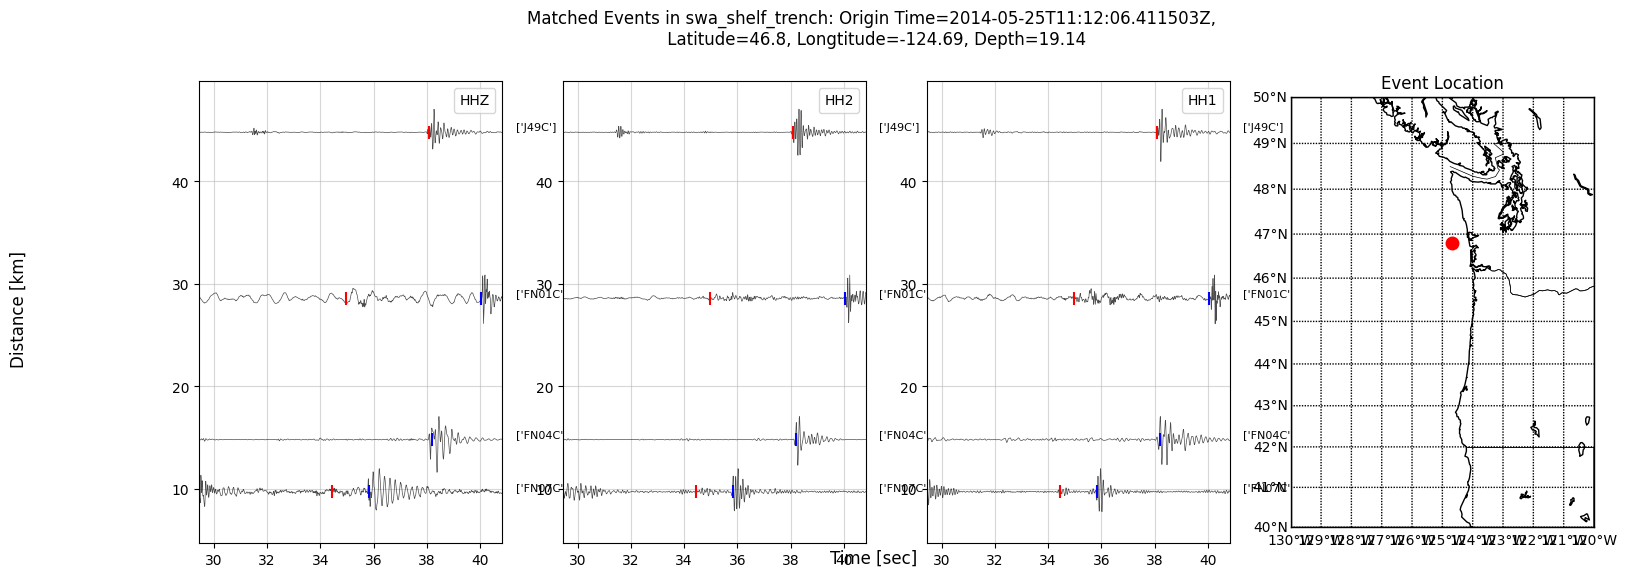

In [122]:
subplots_cluster_scale_rand(mycatalog, mycatalog_picks, all_picks, '?H?', f'Matched Events in {year}', f'{year}.pdf')

In [123]:
year = 'swa_shore'
mycatalog = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/new_events_filtered_{year}.csv',index_col=0)
mycatalog_picks = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/all_pick_assignments_{year}.csv',index_col=0)
all_picks = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/all_picks_all_years_for_assoc_{year}.csv',index_col=0)

  0%|          | 0/5 [00:00<?, ?it/s]

[[None, '7D', 'FN19C', 19.37379907442381], [None, '7D', 'J49C', 22.392554305487018], [None, '7D', 'FN03C', 30.112752067607104], [None, '7D', 'FN04C', 33.50479052490932], [None, '7D', 'FN01C', 34.15976695960193]]
234
234
234
234
234
3 Trace(s) in Stream:
7D.FN19C..HHZ | 2014-01-05T14:12:54.373700Z - 2014-01-05T14:15:24.373700Z | 125.0 Hz, 18751 samples
7D.FN19C..HH2 | 2014-01-05T14:12:54.373700Z - 2014-01-05T14:15:24.373700Z | 125.0 Hz, 18751 samples
7D.FN19C..HH1 | 2014-01-05T14:12:54.373700Z - 2014-01-05T14:15:24.373700Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.J49C..HHZ | 2014-01-05T14:12:54.373000Z - 2014-01-05T14:15:24.373000Z | 125.0 Hz, 18751 samples
7D.J49C..HH2 | 2014-01-05T14:12:54.373000Z - 2014-01-05T14:15:24.373000Z | 125.0 Hz, 18751 samples
7D.J49C..HH1 | 2014-01-05T14:12:54.373000Z - 2014-01-05T14:15:24.373000Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN03C..HHZ | 2014-01-05T14:12:54.369800Z - 2014-01-05T14:15:24.369800Z | 125.0 Hz, 18751 samples
7D.FN

 20%|██        | 1/5 [00:06<00:24,  6.02s/it]

[[None, '7D', 'J49C', 11.34246394883835], [None, '7D', 'FN19C', 22.05450742568919], [None, '7D', 'FN05C', 38.842319984021714], [None, '7D', 'FN01C', 39.09151717573546], [None, '7D', 'FN02C', 45.65708316605902]]
4587
4587
4587
4587
4587
3 Trace(s) in Stream:
7D.J49C..HHZ | 2014-05-10T07:03:53.581200Z - 2014-05-10T07:06:23.581200Z | 125.0 Hz, 18751 samples
7D.J49C..HH2 | 2014-05-10T07:03:53.581200Z - 2014-05-10T07:06:23.581200Z | 125.0 Hz, 18751 samples
7D.J49C..HH1 | 2014-05-10T07:03:53.581200Z - 2014-05-10T07:06:23.581200Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN19C..HHZ | 2014-05-10T07:03:53.577900Z - 2014-05-10T07:06:23.577900Z | 125.0 Hz, 18751 samples
7D.FN19C..HH2 | 2014-05-10T07:03:53.577900Z - 2014-05-10T07:06:23.577900Z | 125.0 Hz, 18751 samples
7D.FN19C..HH1 | 2014-05-10T07:03:53.577900Z - 2014-05-10T07:06:23.577900Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN05C..HHZ | 2014-05-10T07:03:53.580200Z - 2014-05-10T07:06:23.580191Z | 125.0 Hz, 18751 samples
7

 40%|████      | 2/5 [00:11<00:17,  5.83s/it]

[[None, '7D', 'FN19C', 3.497405896873645], [None, '7D', 'FN01C', 17.771607690956433], [None, '7D', 'FN04C', 25.13322800308534], [None, '7D', 'J49C', 32.709425383641495]]
2773
2773
2773
2773
3 Trace(s) in Stream:
7D.FN19C..HHZ | 2014-03-14T12:00:06.590500Z - 2014-03-14T12:02:36.590500Z | 125.0 Hz, 18751 samples
7D.FN19C..HH2 | 2014-03-14T12:00:06.590500Z - 2014-03-14T12:02:36.590500Z | 125.0 Hz, 18751 samples
7D.FN19C..HH1 | 2014-03-14T12:00:06.590500Z - 2014-03-14T12:02:36.590500Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN01C..HHZ | 2014-03-14T12:00:06.590800Z - 2014-03-14T12:02:36.590800Z | 125.0 Hz, 18751 samples
7D.FN01C..HH2 | 2014-03-14T12:00:06.590800Z - 2014-03-14T12:02:36.590800Z | 125.0 Hz, 18751 samples
7D.FN01C..HH1 | 2014-03-14T12:00:06.590800Z - 2014-03-14T12:02:36.590800Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN04C..HHZ | 2014-03-14T12:00:06.588200Z - 2014-03-14T12:02:36.588200Z | 125.0 Hz, 18751 samples
7D.FN04C..HH2 | 2014-03-14T12:00:06.588200Z 

 60%|██████    | 3/5 [00:16<00:11,  5.54s/it]

[[None, '7D', 'J49C', 8.186015287461187], [None, '7D', 'FN19C', 35.012172066954285], [None, '7D', 'FN05C', 47.648058288506974], [None, '7D', 'FN03C', 50.052447844167894], [None, '7D', 'FN04C', 53.65818764740375]]
4164
4164
4164
4164
4164
3 Trace(s) in Stream:
7D.J49C..HHZ | 2014-05-06T10:55:53.295500Z - 2014-05-06T10:58:23.295500Z | 125.0 Hz, 18751 samples
7D.J49C..HH2 | 2014-05-06T10:55:53.295500Z - 2014-05-06T10:58:23.295500Z | 125.0 Hz, 18751 samples
7D.J49C..HH1 | 2014-05-06T10:55:53.295500Z - 2014-05-06T10:58:23.295500Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN19C..HHZ | 2014-05-06T10:55:53.296100Z - 2014-05-06T10:58:23.296100Z | 125.0 Hz, 18751 samples
7D.FN19C..HH2 | 2014-05-06T10:55:53.296100Z - 2014-05-06T10:58:23.296100Z | 125.0 Hz, 18751 samples
7D.FN19C..HH1 | 2014-05-06T10:55:53.296100Z - 2014-05-06T10:58:23.296100Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN05C..HHZ | 2014-05-06T10:55:53.296499Z - 2014-05-06T10:58:23.296490Z | 125.0 Hz, 18751 samples

 80%|████████  | 4/5 [00:22<00:05,  5.48s/it]

[[None, '7D', 'J49C', 14.303814492823717], [None, '7D', 'FN19C', 27.02470343898303], [None, '7D', 'FN03C', 40.1051556346207], [None, '7D', 'FN04C', 43.477895335375315]]
5836
5836
5836
5836
3 Trace(s) in Stream:
7D.J49C..HHZ | 2014-05-23T21:40:46.721300Z - 2014-05-23T21:43:16.721300Z | 125.0 Hz, 18751 samples
7D.J49C..HH2 | 2014-05-23T21:40:46.721300Z - 2014-05-23T21:43:16.721300Z | 125.0 Hz, 18751 samples
7D.J49C..HH1 | 2014-05-23T21:40:46.721300Z - 2014-05-23T21:43:16.721300Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN19C..HHZ | 2014-05-23T21:40:46.720500Z - 2014-05-23T21:43:16.720500Z | 125.0 Hz, 18751 samples
7D.FN19C..HH2 | 2014-05-23T21:40:46.720500Z - 2014-05-23T21:43:16.720500Z | 125.0 Hz, 18751 samples
7D.FN19C..HH1 | 2014-05-23T21:40:46.720500Z - 2014-05-23T21:43:16.720500Z | 125.0 Hz, 18751 samples
3 Trace(s) in Stream:
7D.FN03C..HHZ | 2014-05-23T21:40:46.718400Z - 2014-05-23T21:43:16.718400Z | 125.0 Hz, 18751 samples
7D.FN03C..HH2 | 2014-05-23T21:40:46.718400Z - 20

100%|██████████| 5/5 [00:27<00:00,  5.41s/it]


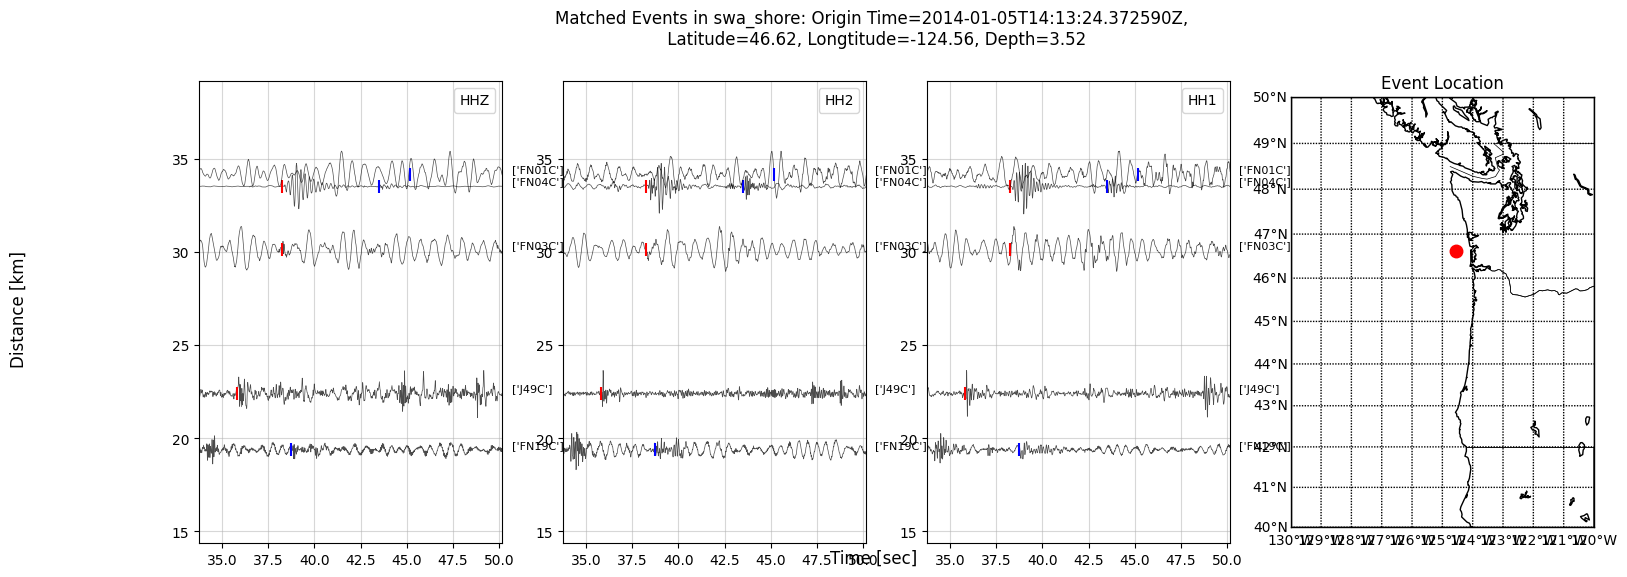

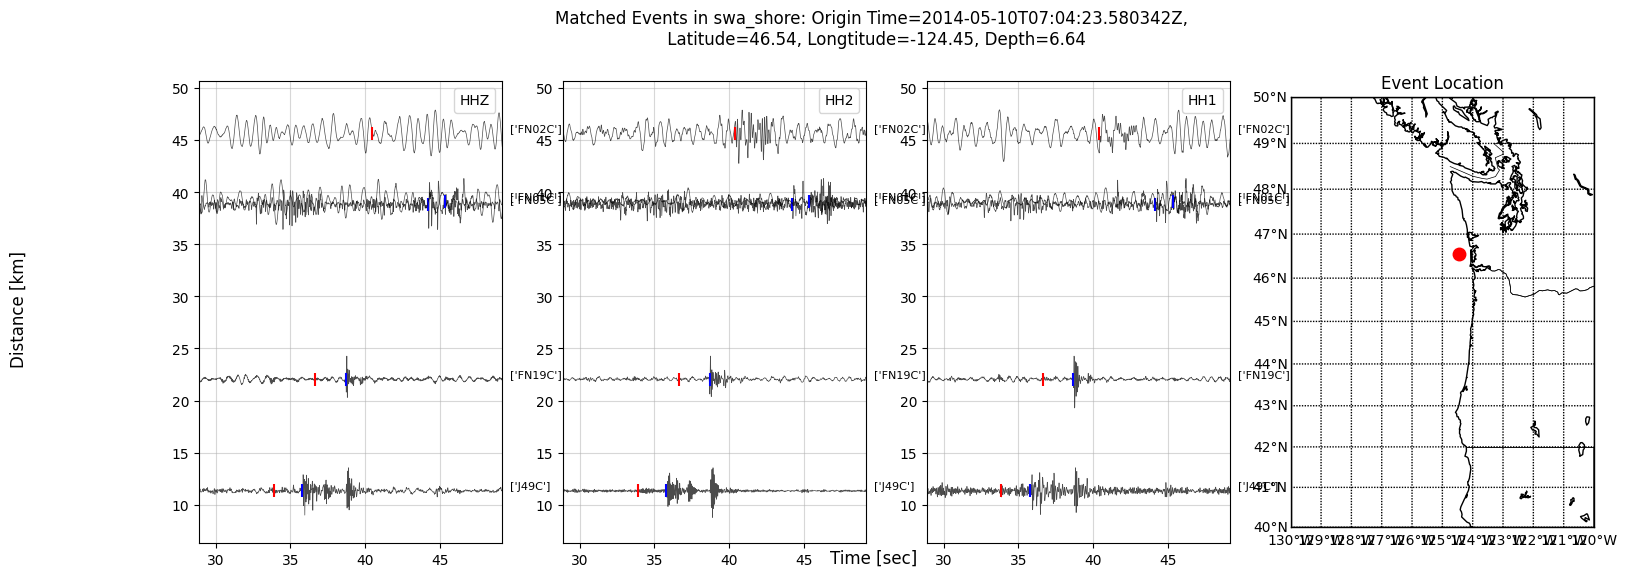

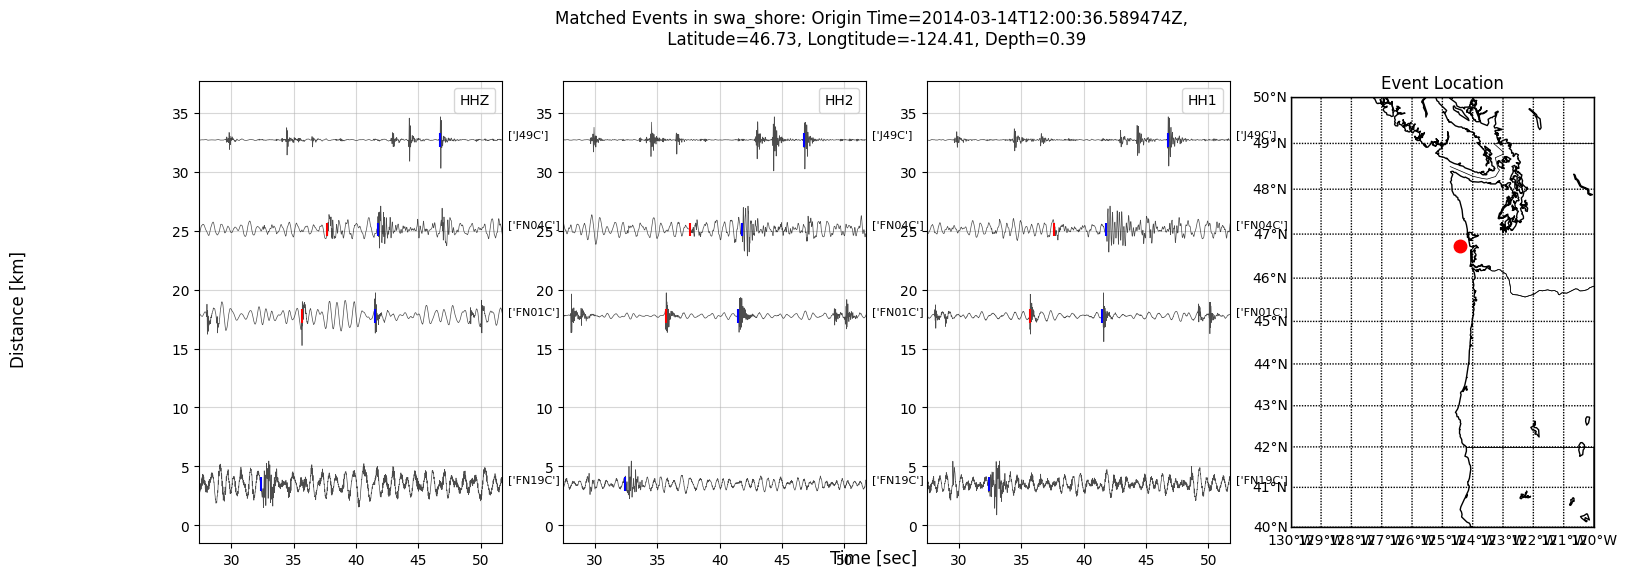

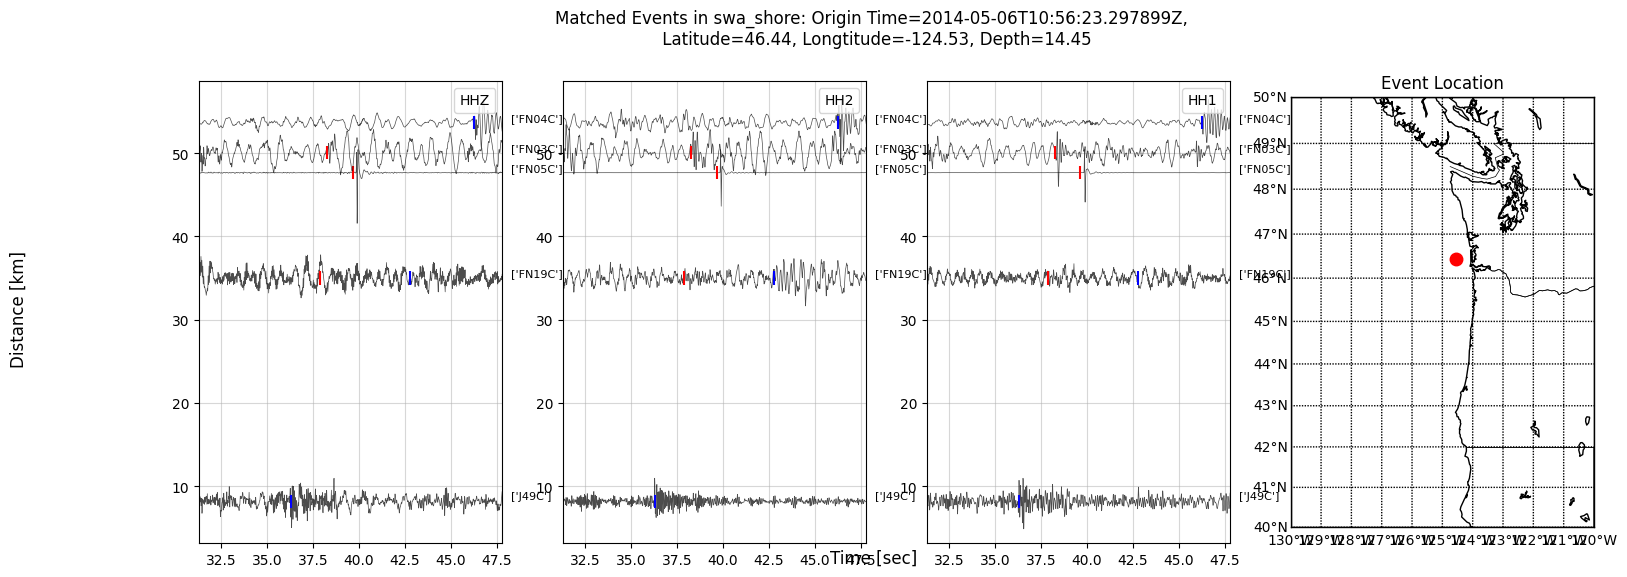

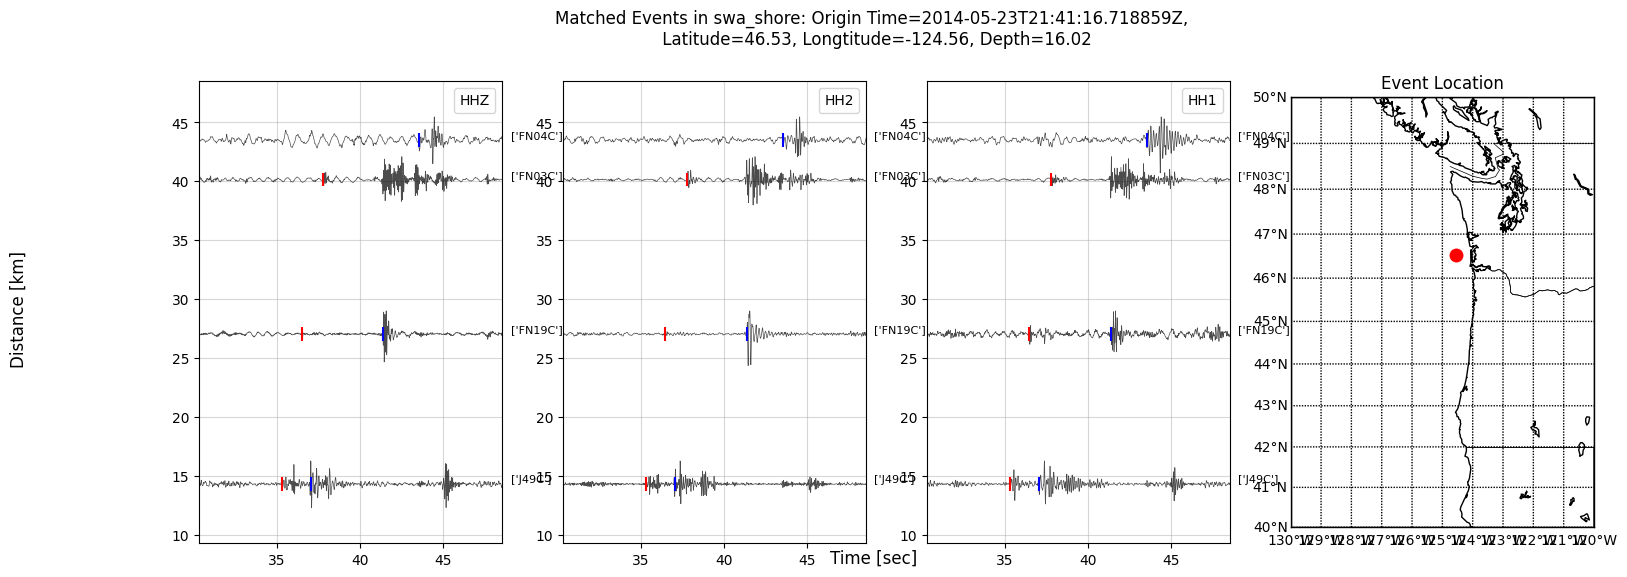

In [124]:
subplots_cluster_scale_rand(mycatalog, mycatalog_picks, all_picks, '?H?', f'Matched Events in {year}', f'{year}.pdf')

In [108]:
year = 'pnsn_wa'
mycatalog = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/new_events_filtered_{year}.csv',index_col=0)
mycatalog_picks = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/all_pick_assignments_{year}.csv',index_col=0)
all_picks = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/all_picks_all_years_for_assoc_{year}.csv',index_col=0)

UW,CN,TA,7D,C8


  0%|          | 0/5 [00:00<?, ?it/s]

[[None, 'CN', 'SNB', 20.243497528969055], [None, 'C8', 'PA01', 30.114142711394457], [None, 'C8', 'PA02', 30.24046129190925], [None, 'C8', 'PA12', 30.240916307712542], [None, 'CN', 'PGC', 30.44493524932524], [None, 'CN', 'VGZ', 30.6762126844523], [None, 'CN', 'CLRS', 83.14161431874346], [None, 'CN', 'SHB', 125.15386003758887]]
6786
6786
6786
6786
6786
6786
6786
6786
3 Trace(s) in Stream:
CN.SNB..HHN | 2015-03-20T06:37:29.350000Z - 2015-03-20T06:39:59.350000Z | 100.0 Hz, 15001 samples
CN.SNB..HHZ | 2015-03-20T06:37:29.350000Z - 2015-03-20T06:39:59.350000Z | 100.0 Hz, 15001 samples
CN.SNB..HHE | 2015-03-20T06:37:29.350000Z - 2015-03-20T06:39:59.350000Z | 100.0 Hz, 15001 samples
3 Trace(s) in Stream:
C8.PA01..HHN | 2015-03-20T06:37:29.350000Z - 2015-03-20T06:39:59.350000Z | 100.0 Hz, 15001 samples
C8.PA01..HHZ | 2015-03-20T06:37:29.350000Z - 2015-03-20T06:39:59.350000Z | 100.0 Hz, 15001 samples
C8.PA01..HHE | 2015-03-20T06:37:29.350000Z - 2015-03-20T06:39:59.350000Z | 100.0 Hz, 15001 sampl

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


3 Trace(s) in Stream:
CN.SHB..BHN | 2015-03-20T06:37:29.350000Z - 2015-03-20T06:39:59.350000Z | 40.0 Hz, 6001 samples
CN.SHB..BHZ | 2015-03-20T06:37:29.350000Z - 2015-03-20T06:39:59.350000Z | 40.0 Hz, 6001 samples
CN.SHB..BHE | 2015-03-20T06:37:29.350000Z - 2015-03-20T06:39:59.350000Z | 40.0 Hz, 6001 samples


 20%|██        | 1/5 [00:06<00:24,  6.21s/it]

[[None, 'CN', 'VGZ', 33.47496578563908], [None, 'CN', 'CLRS', 41.598992795222586], [None, 'CN', 'PFB', 59.69489884666887]]
8160
8160
8160
3 Trace(s) in Stream:
CN.VGZ..HHN | 2015-08-19T06:21:31.830000Z - 2015-08-19T06:24:01.830000Z | 100.0 Hz, 15001 samples
CN.VGZ..HHZ | 2015-08-19T06:21:31.830000Z - 2015-08-19T06:24:01.830000Z | 100.0 Hz, 15001 samples
CN.VGZ..HHE | 2015-08-19T06:21:31.830000Z - 2015-08-19T06:24:01.830000Z | 100.0 Hz, 15001 samples
3 Trace(s) in Stream:
CN.CLRS..HHN | 2015-08-19T06:21:31.830000Z - 2015-08-19T06:24:01.830000Z | 100.0 Hz, 15001 samples
CN.CLRS..HHZ | 2015-08-19T06:21:31.830000Z - 2015-08-19T06:24:01.830000Z | 100.0 Hz, 15001 samples
CN.CLRS..HHE | 2015-08-19T06:21:31.830000Z - 2015-08-19T06:24:01.830000Z | 100.0 Hz, 15001 samples
3 Trace(s) in Stream:
CN.PFB..HHN | 2015-08-19T06:21:31.830000Z - 2015-08-19T06:24:01.830000Z | 100.0 Hz, 15001 samples
CN.PFB..HHZ | 2015-08-19T06:21:31.830000Z - 2015-08-19T06:24:01.830000Z | 100.0 Hz, 15001 samples
CN.PFB..H

 40%|████      | 2/5 [00:09<00:13,  4.53s/it]

[[None, 'CN', 'SNB', 4.630274516167437], [None, 'C8', 'PA01', 19.846329479900277], [None, 'C8', 'PA02', 20.011285911068413], [None, 'C8', 'PA12', 20.29619290984042], [None, 'CN', 'PGC', 20.33300258022679], [None, 'CN', 'SHB', 104.34921719525471]]
5501
5501
5501
5501
5501
5501
3 Trace(s) in Stream:
CN.SNB..HHN | 2015-01-01T05:07:35.850000Z - 2015-01-01T05:10:05.850000Z | 100.0 Hz, 15001 samples
CN.SNB..HHZ | 2015-01-01T05:07:35.850000Z - 2015-01-01T05:10:05.850000Z | 100.0 Hz, 15001 samples
CN.SNB..HHE | 2015-01-01T05:07:36.000000Z - 2015-01-01T05:10:05.850000Z | 100.0 Hz, 14986 samples
3 Trace(s) in Stream:
C8.PA01..HHN | 2015-01-01T05:07:35.850000Z - 2015-01-01T05:10:05.850000Z | 100.0 Hz, 15001 samples
C8.PA01..HHZ | 2015-01-01T05:07:35.850000Z - 2015-01-01T05:10:05.850000Z | 100.0 Hz, 15001 samples
C8.PA01..HHE | 2015-01-01T05:07:35.850000Z - 2015-01-01T05:10:05.850000Z | 100.0 Hz, 15001 samples
3 Trace(s) in Stream:
C8.PA02..HHN | 2015-01-01T05:07:35.850000Z - 2015-01-01T05:10:05.8

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
 60%|██████    | 3/5 [00:15<00:10,  5.18s/it]

[[None, 'CN', 'SNB', 4.630274516167437], [None, 'C8', 'PA01', 19.846329479900277], [None, 'C8', 'PA12', 20.29619290984042], [None, 'CN', 'PGC', 20.33300258022679]]
5810
5810
5810
5810
3 Trace(s) in Stream:
CN.SNB..HHN | 2015-01-23T04:00:16.500000Z - 2015-01-23T04:02:46.500000Z | 100.0 Hz, 15001 samples
CN.SNB..HHZ | 2015-01-23T04:00:16.500000Z - 2015-01-23T04:02:35.990000Z | 100.0 Hz, 13950 samples
CN.SNB..HHE | 2015-01-23T04:00:16.500000Z - 2015-01-23T04:02:46.500000Z | 100.0 Hz, 15001 samples
3 Trace(s) in Stream:
C8.PA01..HHN | 2015-01-23T04:00:16.500000Z - 2015-01-23T04:02:46.500000Z | 100.0 Hz, 15001 samples
C8.PA01..HHZ | 2015-01-23T04:00:16.500000Z - 2015-01-23T04:02:46.500000Z | 100.0 Hz, 15001 samples
C8.PA01..HHE | 2015-01-23T04:00:16.500000Z - 2015-01-23T04:02:46.500000Z | 100.0 Hz, 15001 samples
3 Trace(s) in Stream:
C8.PA12..HHN | 2015-01-23T04:00:16.500000Z - 2015-01-23T04:02:46.500000Z | 100.0 Hz, 15001 samples
C8.PA12..HHZ | 2015-01-23T04:00:16.500000Z - 2015-01-23T04:0

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
 80%|████████  | 4/5 [00:20<00:04,  4.96s/it]

[[None, 'CN', 'LZB', 21.515177200523937], [None, 'CN', 'PGC', 48.74560806183688], [None, 'CN', 'SNB', 70.96586898762412], [None, 'CN', 'SHB', 108.76183780762355], [None, 'UW', 'WISH', 170.49743919701538]]
325
325
325
325
325


/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


3 Trace(s) in Stream:
CN.LZB..BHN | 2011-03-08T01:28:50.475000Z - 2011-03-08T01:31:20.475000Z | 40.0 Hz, 6001 samples
CN.LZB..BHZ | 2011-03-08T01:28:50.475000Z - 2011-03-08T01:31:20.475000Z | 40.0 Hz, 6001 samples
CN.LZB..BHE | 2011-03-08T01:28:50.475000Z - 2011-03-08T01:31:20.475000Z | 40.0 Hz, 6001 samples
3 Trace(s) in Stream:
CN.PGC..BHN | 2011-03-08T01:28:50.475000Z - 2011-03-08T01:31:20.475000Z | 40.0 Hz, 6001 samples
CN.PGC..BHZ | 2011-03-08T01:28:50.475000Z - 2011-03-08T01:31:20.475000Z | 40.0 Hz, 6001 samples
CN.PGC..BHE | 2011-03-08T01:28:50.475000Z - 2011-03-08T01:31:20.475000Z | 40.0 Hz, 6001 samples
3 Trace(s) in Stream:
CN.SNB..BHN | 2011-03-08T01:28:50.475000Z - 2011-03-08T01:31:20.475000Z | 40.0 Hz, 6001 samples
CN.SNB..BHZ | 2011-03-08T01:28:50.475000Z - 2011-03-08T01:31:20.475000Z | 40.0 Hz, 6001 samples
CN.SNB..BHE | 2011-03-08T01:28:50.475000Z - 2011-03-08T01:31:20.475000Z | 40.0 Hz, 6001 samples
3 Trace(s) in Stream:
CN.SHB..BHN | 2011-03-08T01:28:50.475000Z - 2011

100%|██████████| 5/5 [00:26<00:00,  5.28s/it]


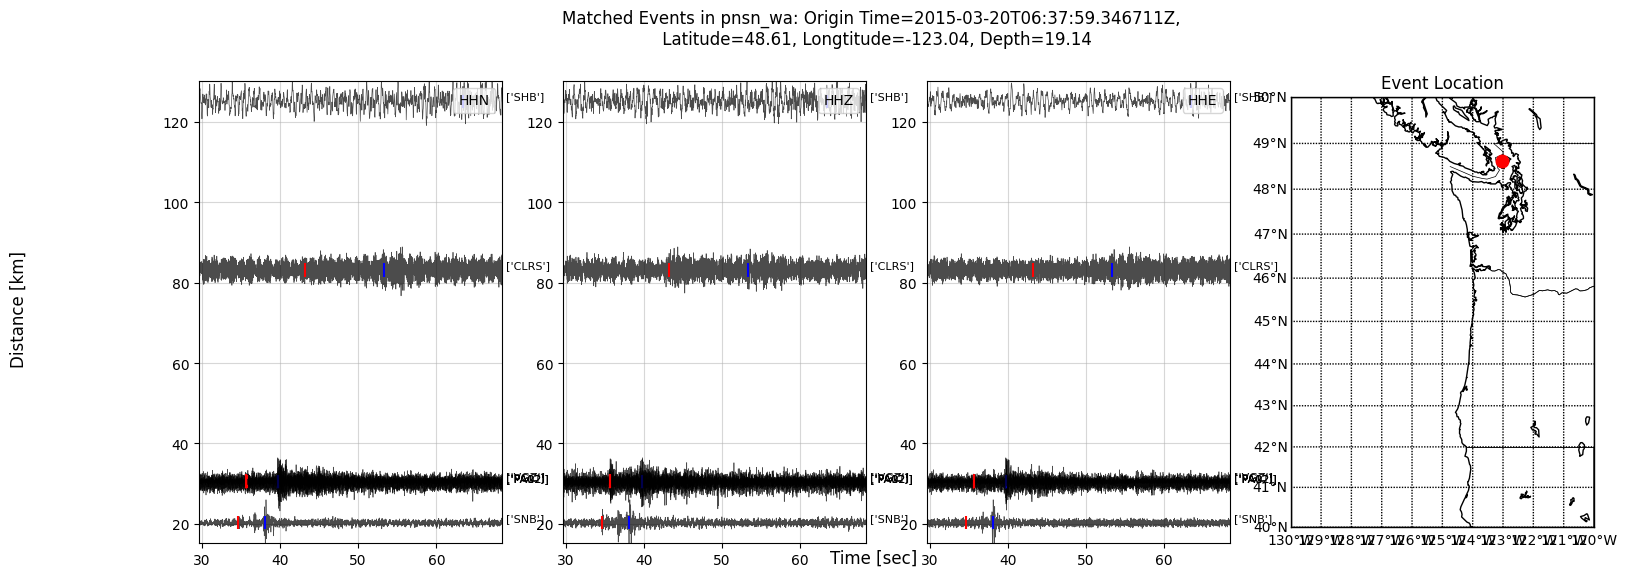

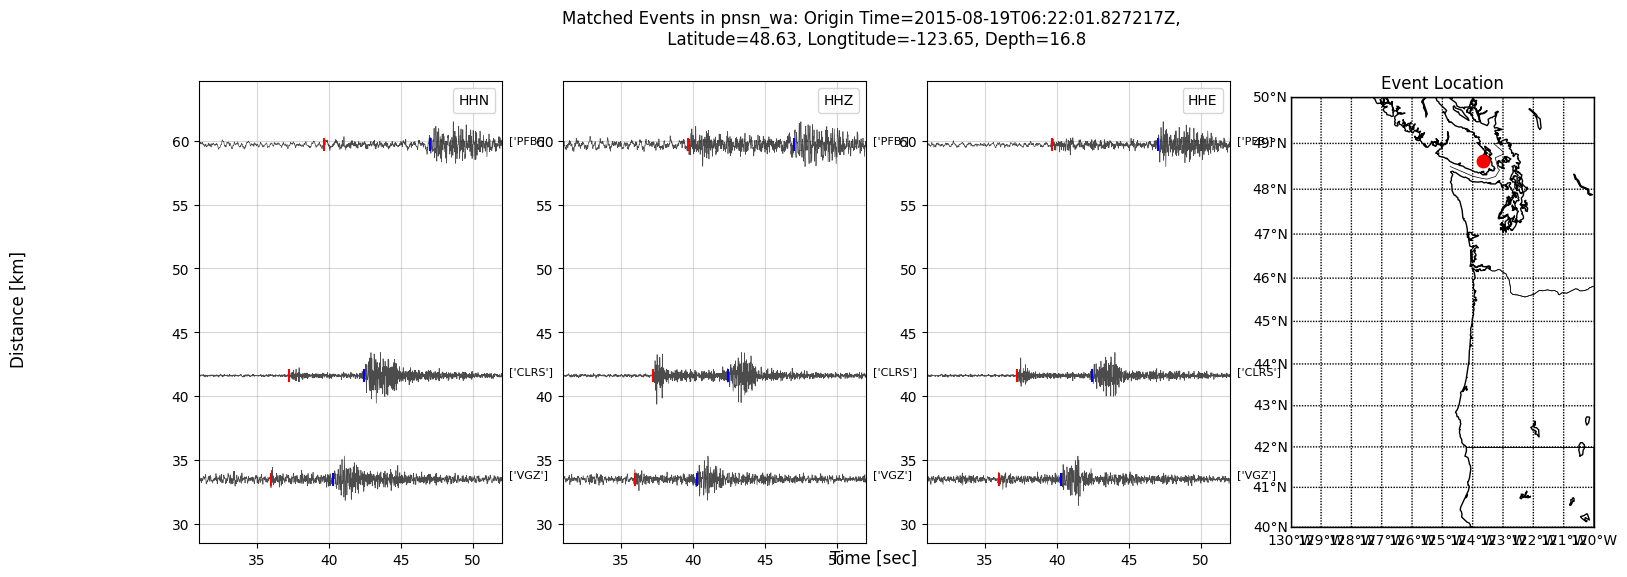

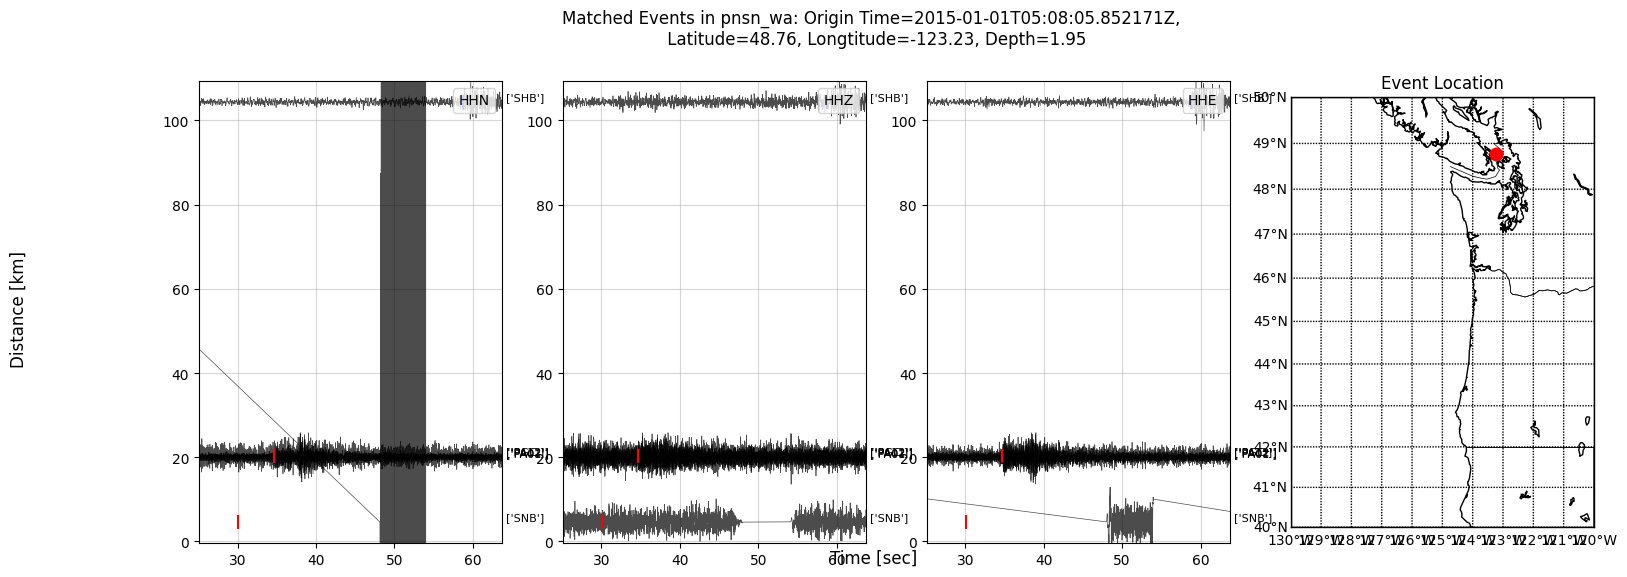

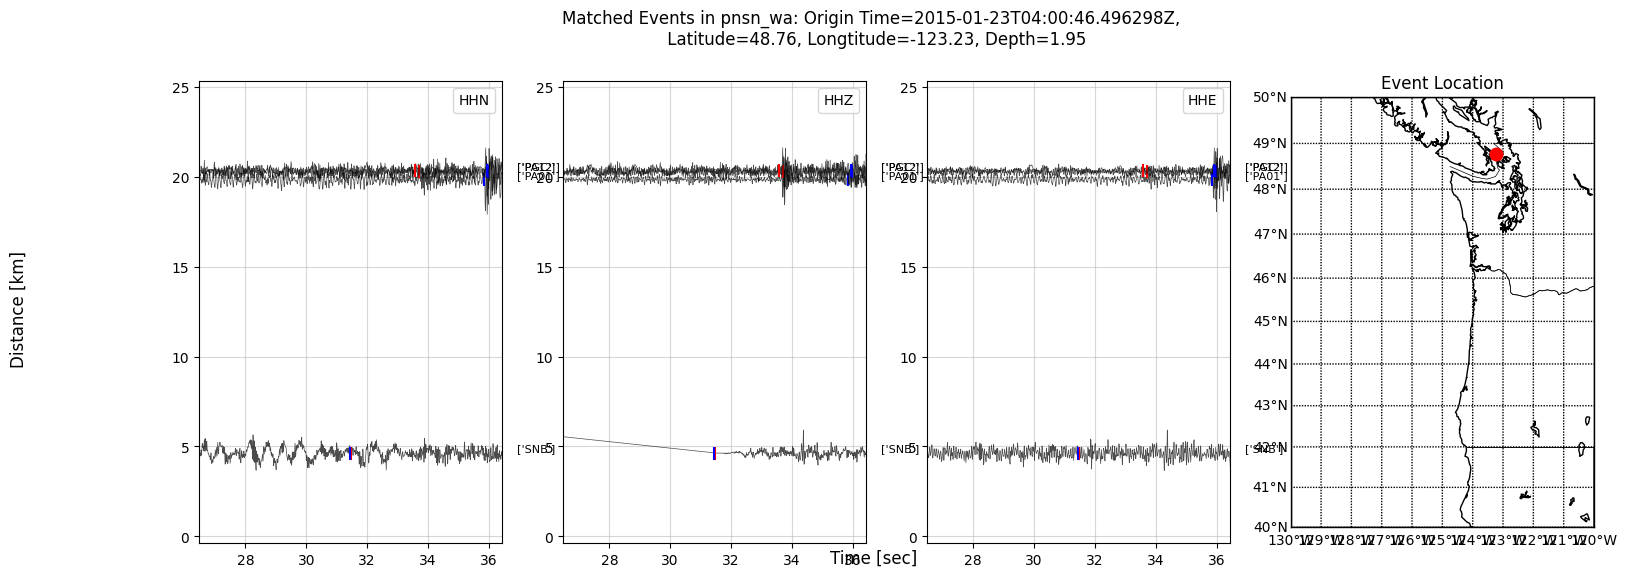

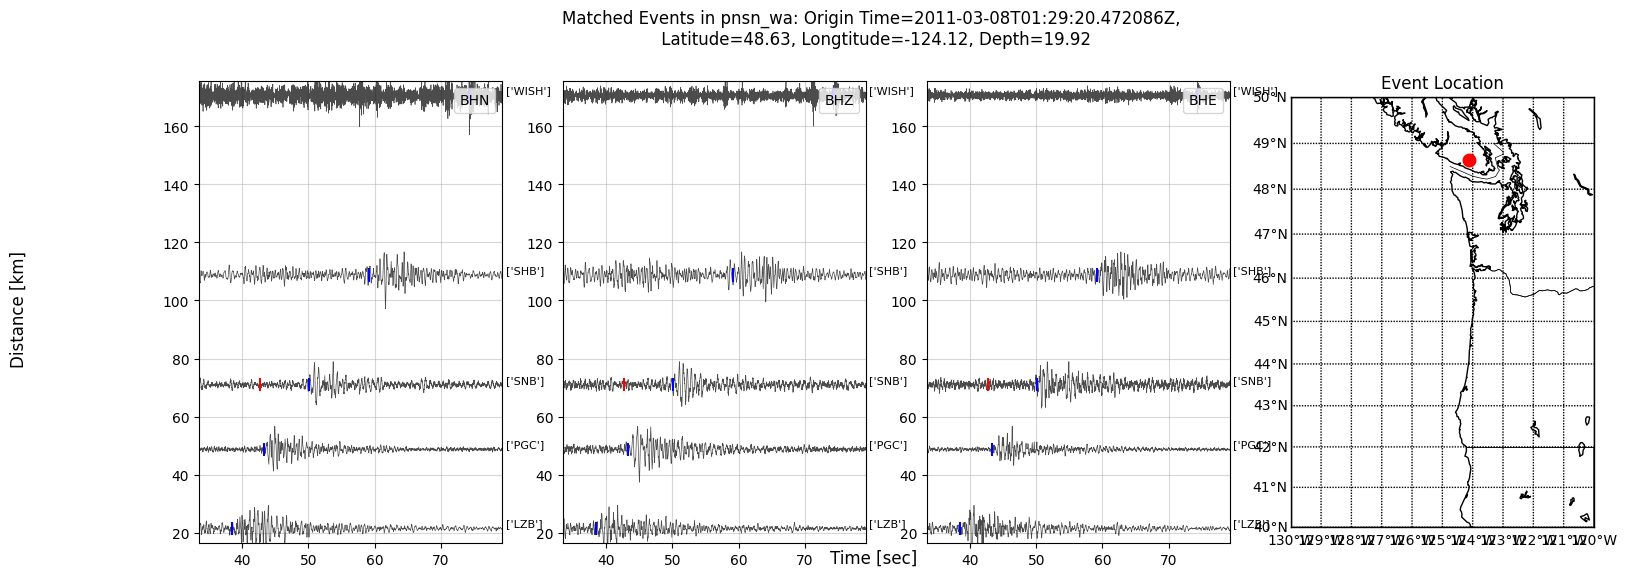

In [109]:
subplots_cluster_scale_rand(mycatalog, mycatalog_picks, all_picks, '?H?', f'Matched Events in {year}', f'{year}.pdf')